In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

In [5]:
# Each entry of the flights.csv file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

# YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
# AIRLINE: An identification number assigned by US DOT to identify a unique airline
# ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports
# SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing
# DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place
# DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times
# DISTANCE: distance (in miles)


### The main goal of this project is to predict arrival delay

In [6]:
# I remove Nans from columns where flights were cancelled (or diverted)
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)
# I remove columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# I remove columns with insufficient data
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [7]:
# In the initial dataframe, dates are coded according to 4 variables: YEAR, MONTH, DAY, and DAY_OF_WEEK. 
# I change it into datetime format:
import datetime
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
# I'll need name of the week and month name
df['DAY_NAME'] = df['DATE'].dt.day_name()
df['MONTH_NAME'] = df['DATE'].dt.month_name()
# I remove those 4 unnecessary columns
df.drop(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK'], axis=1, inplace=True)

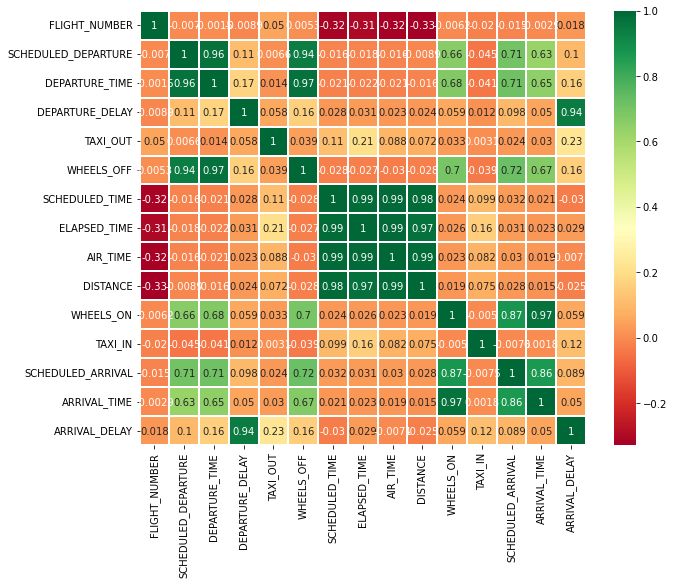

In [8]:
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

### Departure_delay column is the most correlated data with arrival_delay, but I want to predict arrival delays before the flight.

In [9]:
# Our goal is to predict if the arrival will be delayed, that's why I removed columns 
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'DEPARTURE_DELAY', 'DEPARTURE_TIME',
             'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME'], axis=1, inplace=True)

In [10]:
df.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME
2815887,UA,LAX,ORD,1344,251.0,1744,1955,24.0,2015-06-26,Friday,June
246162,NK,ORD,MSP,1952,87.0,334,2119,-3.0,2015-01-16,Friday,January
2795888,EV,SYR,EWR,1108,82.0,195,1230,-31.0,2015-06-25,Thursday,June
5369980,B6,SJU,MCO,2002,183.0,1189,2205,-19.0,2015-12-02,Wednesday,December
3638524,F9,TTN,DTW,1400,100.0,464,1540,-23.0,2015-08-14,Friday,August
3211112,DL,MSN,ATL,1057,133.0,707,1410,-18.0,2015-07-20,Monday,July
2505828,EV,IND,IAH,910,141.0,844,1031,26.0,2015-06-08,Monday,June
1186711,B6,ORD,BOS,1720,138.0,867,2038,6.0,2015-03-18,Wednesday,March
1068148,EV,CHS,ORD,1317,148.0,760,1445,-21.0,2015-03-11,Wednesday,March
465213,WN,BDL,MCO,1420,190.0,1050,1730,-14.0,2015-01-31,Saturday,January


In [12]:
# SCHEDULED_DEPARTURE and _ARRIVAL - this columns shows hours and minutes from departures and arrivals
# I'm changing it into full hours
df['SCHEDULED_DEPARTURE_H'] = df['SCHEDULED_DEPARTURE'] // 100
df['SCHEDULED_ARRIVAL_H'] = df['SCHEDULED_ARRIVAL'] // 100
# Remove column SCHEDULED_DEPARTURE:
df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1, inplace=True)

In [13]:
# In the data there was one position with hour = 24 (should be 00)
df[df['SCHEDULED_ARRIVAL_H'] == 24]
df.loc[1124523,'SCHEDULED_ARRIVAL_H'] = 0
df.loc[1124523]

AIRLINE                                   F9
ORIGIN_AIRPORT                           TPA
DESTINATION_AIRPORT                      PHL
SCHEDULED_TIME                         145.0
DISTANCE                                 920
ARRIVAL_DELAY                           84.0
DATE                     2015-03-14 00:00:00
DAY_NAME                            Saturday
MONTH_NAME                             March
SCHEDULED_DEPARTURE_H                     21
SCHEDULED_ARRIVAL_H                        0
Name: 1124523, dtype: object

## An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [14]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [15]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [16]:
# Chcking the Nan values
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [17]:
# taking real world data for Plattsburgh International Airport:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805

In [18]:
airports[airports['AIRPORT'] == 'Plattsburgh International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,44.3903,-73.2805


In [19]:
# taking real world data also for other two Airports:
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [20]:
# In airports.csv we have airports only from one country - USA
airports['COUNTRY'].value_counts()

USA    322
Name: COUNTRY, dtype: int64

In [21]:
# In airports.csv we have airports from 54 states of USA
airports['STATE'].unique().shape

(54,)

In [22]:
# In the dataframe there are also airports that are not in the airport.csv file
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [23]:
# I remove the data where airports are shown in 5-digit code
df_air = df[df['ORIGIN_AIRPORT'] > 'AAA']
df_air.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME,SCHEDULED_DEPARTURE_H,SCHEDULED_ARRIVAL_H
3883663,OO,ABR,MSP,72.0,257,-20.0,2015-08-29,Saturday,August,15,16
2846481,DL,MSN,DTW,72.0,311,5.0,2015-06-28,Sunday,June,12,14
775043,WN,TPA,FNT,165.0,1036,98.0,2015-02-20,Friday,February,19,22
4966050,EV,CLE,BOS,105.0,563,-11.0,2015-11-06,Friday,November,18,19
1435231,DL,MSP,DTW,99.0,528,-12.0,2015-04-02,Thursday,April,19,22
995119,AA,DFW,LAX,204.0,1235,-19.0,2015-03-06,Friday,March,20,22
5488632,HA,OGG,HNL,37.0,100,3.0,2015-12-10,Thursday,December,15,15
1265041,MQ,CMI,ORD,62.0,135,146.0,2015-03-23,Monday,March,14,15
5557404,WN,MDW,RDU,115.0,632,-27.0,2015-12-15,Tuesday,December,8,10
2455553,AA,ORD,DFW,154.0,802,-6.0,2015-06-05,Friday,June,7,9


In [24]:
df_air.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AIRLINE                5231130 non-null  object        
 1   ORIGIN_AIRPORT         5231130 non-null  object        
 2   DESTINATION_AIRPORT    5231130 non-null  object        
 3   SCHEDULED_TIME         5231130 non-null  float64       
 4   DISTANCE               5231130 non-null  int64         
 5   ARRIVAL_DELAY          5231130 non-null  float64       
 6   DATE                   5231130 non-null  datetime64[ns]
 7   DAY_NAME               5231130 non-null  object        
 8   MONTH_NAME             5231130 non-null  object        
 9   SCHEDULED_DEPARTURE_H  5231130 non-null  int64         
 10  SCHEDULED_ARRIVAL_H    5231130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 478.9+ MB


## An additional file of this dataset, the airlines.csv file, gives a more exhaustive description of the airlines:

In [25]:
airlines_names=pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [26]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

C:\Users\HP\AppData\Local\Temp\ipykernel_7624\323634728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['DELAY_LEVEL'] = df_air['ARRIVAL_DELAY'].apply(delay_type)


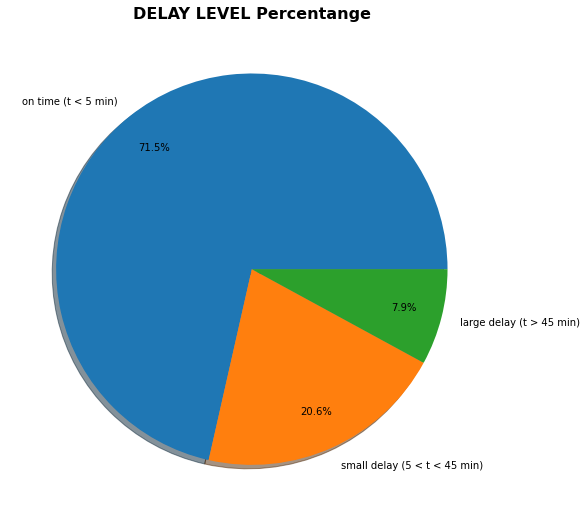

In [27]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df_air['DELAY_LEVEL'] = df_air['ARRIVAL_DELAY'].apply(delay_type)

# 
delay_level = dict(df_air.groupby('DELAY_LEVEL')['DELAY_LEVEL'].count())
labels = ['on time (t < 5 min)', 'small delay (5 < t < 45 min)', 'large delay (t > 45 min)']
values = delay_level.values()
plt.figure(figsize=(9,9))
plt.pie(data=df_air, x=values, labels= labels, autopct = '%1.1f%%', pctdistance=0.8, shadow=True)
plt.title('DELAY LEVEL Percentange', fontsize=16, weight = 'bold')
plt.show()

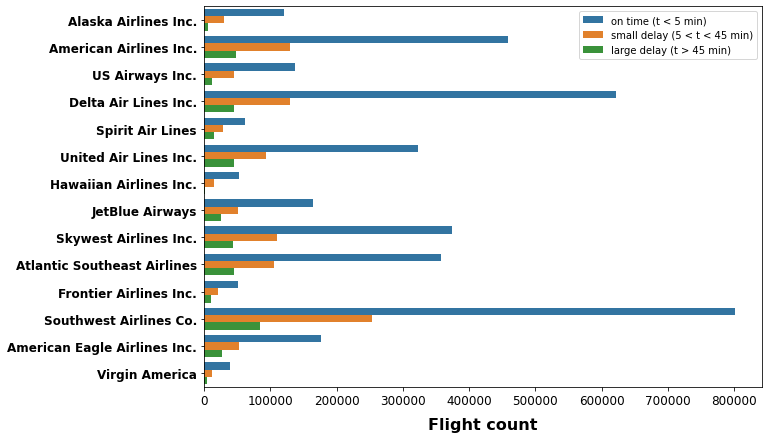

In [28]:
# Bar chart: Flight count delays vs airlines companies
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df_air)

# Replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

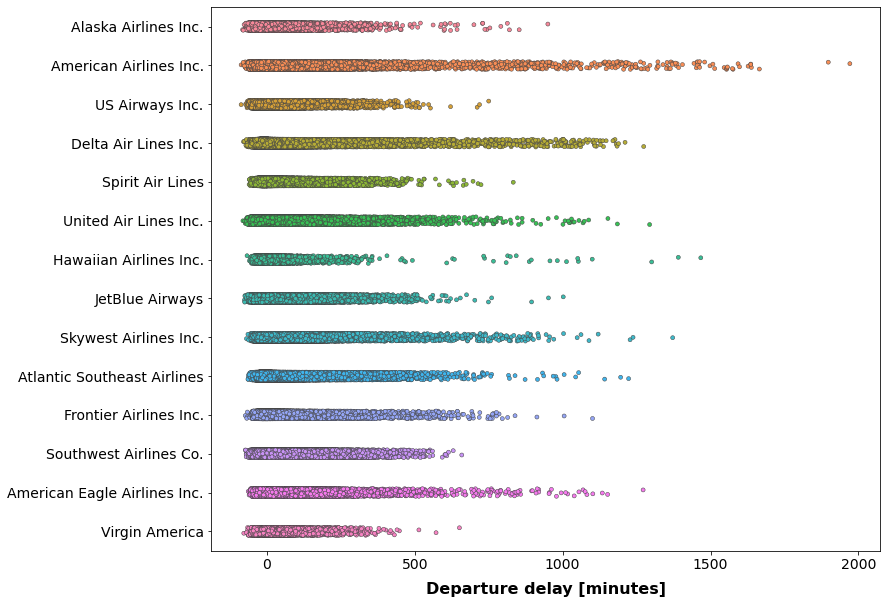

In [29]:
# I extract a subset of columns and redefine the airlines labeling 
df2 = df_air.loc[:, ['AIRLINE', 'ARRIVAL_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

plt.figure(figsize=(12,10))
ax = sns.stripplot(y="AIRLINE", x="ARRIVAL_DELAY", size = 4, 
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlabel('Departure delay [minutes]', fontsize=16, weight = 'bold', labelpad=10)
ax.yaxis.label.set_visible(False)
plt.show()

## Time charts

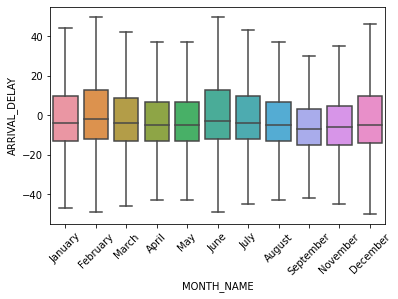

In [30]:
# Boxplot:  Month name vs arrival_delay
sns.boxplot(x='MONTH_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.xticks(rotation=45)
plt.show()

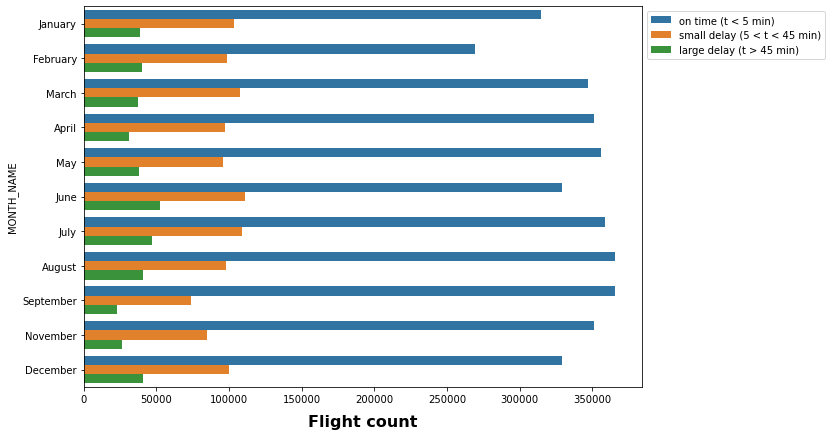

In [31]:
# Bar chart: Flight count delays vs month name
fig = plt.figure(1, figsize=(10,7))
sns.countplot(y="MONTH_NAME", hue='DELAY_LEVEL', data=df_air)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

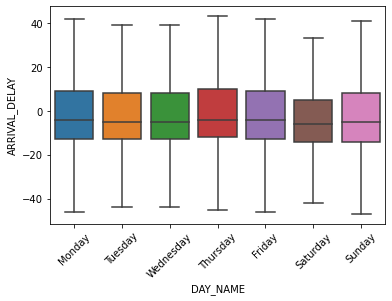

In [32]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='DAY_NAME', y='ARRIVAL_DELAY', data=df_air, showfliers=False, order=weekdays)
plt.xticks(rotation=45)
plt.show()

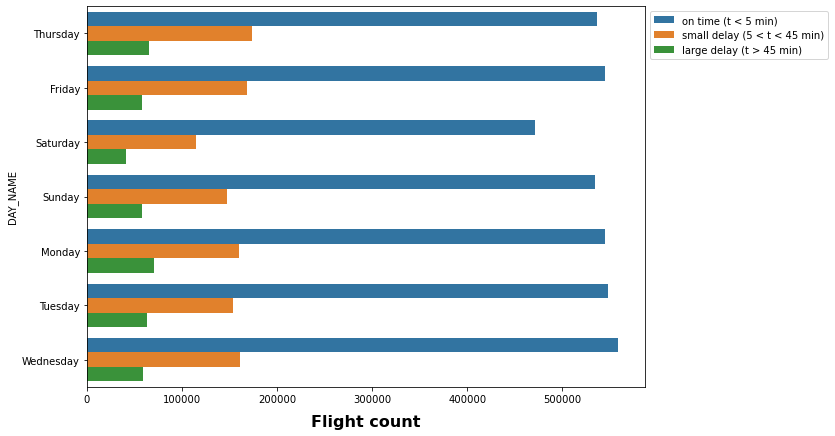

In [33]:
# Bar chart: Flight count delays vs day name
fig = plt.figure(1, figsize=(10,7))
sns.countplot(y="DAY_NAME", hue='DELAY_LEVEL', data=df_air)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

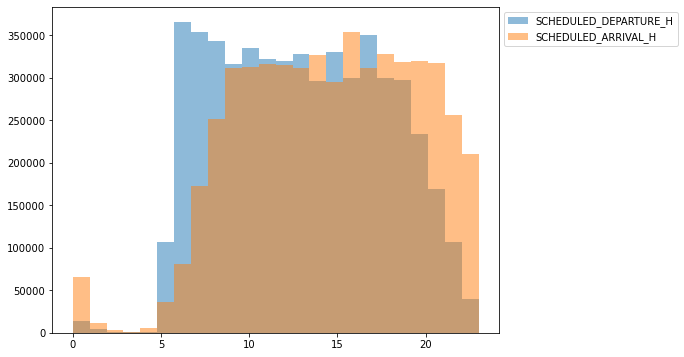

In [34]:
fig, ax=plt.subplots(figsize=(8,6))
ax.hist(df_air['SCHEDULED_DEPARTURE_H'], label='SCHEDULED_DEPARTURE_H', alpha=0.5, bins=24)
ax.hist(df_air['SCHEDULED_ARRIVAL_H'], label='SCHEDULED_ARRIVAL_H', alpha=0.5, bins=24)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

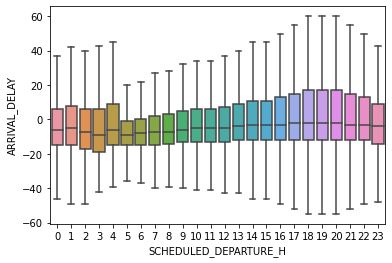

In [35]:
sns.boxplot(x='SCHEDULED_DEPARTURE_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

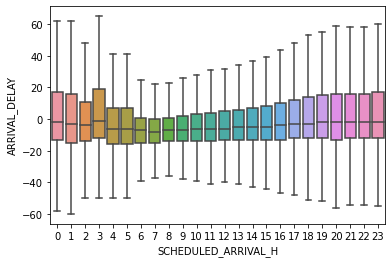

In [36]:
sns.boxplot(x='SCHEDULED_ARRIVAL_H', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

In [37]:
mapping = {0:'night', 1:'night', 2:'night', 3:'night', 4:'night', 5:'night', 
          6:'morning', 7:'morning', 8:'morning', 9:'morning', 10:'morning', 11:'morning',
          12:'afternoon', 13:'afternoon', 14:'afternoon', 15:'afternoon', 16:'afternoon', 17:'afternoon',
          18:'evening', 19:'evening', 20:'evening', 21:'evening', 22:'evening', 23:'evening'}
df_air['SCHEDULED_DEPARTURE_time'] = df_air['SCHEDULED_DEPARTURE_H'].map(mapping)
df_air['SCHEDULED_ARRIVAL_time'] = df_air['SCHEDULED_ARRIVAL_H'].map(mapping)

C:\Users\HP\AppData\Local\Temp\ipykernel_7624\1367692990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['SCHEDULED_DEPARTURE_time'] = df_air['SCHEDULED_DEPARTURE_H'].map(mapping)
C:\Users\HP\AppData\Local\Temp\ipykernel_7624\1367692990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['SCHEDULED_ARRIVAL_time'] = df_air['SCHEDULED_ARRIVAL_H'].map(mapping)


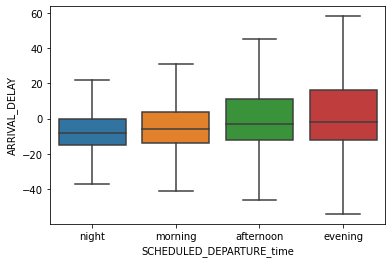

In [38]:
sns.boxplot(x='SCHEDULED_DEPARTURE_time', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

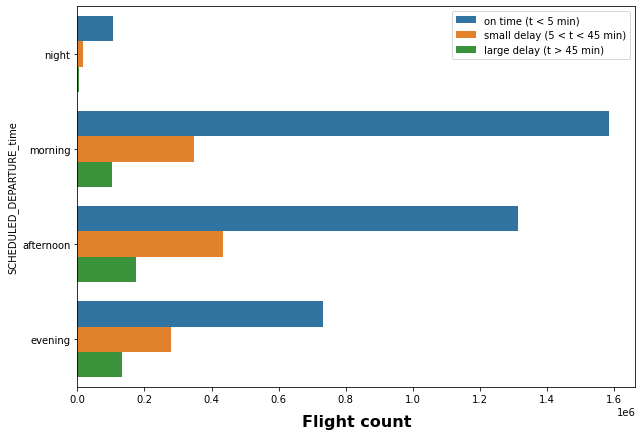

In [39]:
# Bar chart: Flight count delays vs SCHEDULED_DEPARTURE_time category
fig = plt.figure(1, figsize=(10,7))
sns.countplot(y="SCHEDULED_DEPARTURE_time", hue='DELAY_LEVEL', data=df_air)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

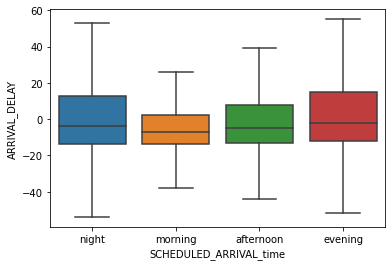

In [40]:
sns.boxplot(x='SCHEDULED_ARRIVAL_time', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

In [41]:
df_air.groupby('SCHEDULED_ARRIVAL_time')['DELAY_LEVEL'].value_counts()

SCHEDULED_ARRIVAL_time  DELAY_LEVEL
afternoon               0              1378221
                        1               395218
                        2               139746
evening                 0              1122559
                        1               427966
                        2               199155
morning                 0              1154970
                        1               226553
                        2                63643
night                   0                82355
                        1                28098
                        2                12646
Name: DELAY_LEVEL, dtype: int64

In [42]:
# Now, I'll check size of airports, by counting the departures:
airport_size = df_air['ORIGIN_AIRPORT'].value_counts().rename_axis('IATA_CODE').reset_index(name='counts')
airport_size['size'] = pd.cut(airport_size['counts'], bins=[0,1000,10000,100000,500000],
                              labels=['small','medium','big','huge'])
airport_size['size'].value_counts()

medium    148
small      98
big        62
huge       14
Name: size, dtype: int64

In [43]:
stats = df_air.groupby('ORIGIN_AIRPORT').agg(count=('ORIGIN_AIRPORT', 'size'), 
                                             mean_delay=('ARRIVAL_DELAY', 'mean')).reset_index()
stats['size'] = pd.cut(stats['count'], bins=[0, 750, 2500, 10000, 25000, 500000],
                              labels=['very small', 'small', 'medium','big','huge'])
stats

,ORIGIN_AIRPORT,count,mean_delay,size
0,ABE,2227,6.249663,small
1,ABI,2231,3.272075,small
2,ABQ,18918,4.768263,big
3,ABR,663,9.909502,very small
4,ABY,866,7.587760,small
...,...,...,...,...
317,WRG,649,4.667180,very small
318,WYS,208,-1.865385,very small
319,XNA,8963,11.233850,medium
320,YAK,650,-5.632308,very small


In [44]:
stats['size'].value_counts()

medium        86
small         84
very small    76
huge          47
big           29
Name: size, dtype: int64

<AxesSubplot:xlabel='size', ylabel='mean_delay'>

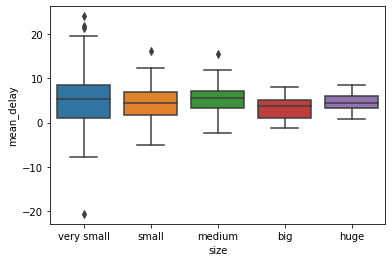

In [45]:
sns.boxplot(x='size', y='mean_delay', data=stats)

In [46]:
df3 = df_air.loc[:, ['ORIGIN_AIRPORT', 'ARRIVAL_DELAY']]
df4 = df3.merge(airports, how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
df4

,ORIGIN_AIRPORT,ARRIVAL_DELAY,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ANC,-22.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,ANC,-14.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
2,ANC,-24.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
3,ANC,-18.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
4,ANC,-10.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
...,...,...,...,...,...,...,...,...,...
5231125,HYA,-9.0,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036
5231126,HYA,-28.0,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036
5231127,HYA,-20.0,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036
5231128,HYA,-27.0,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036


In [47]:
df_air['DATE'].nunique()

334

In [48]:
delay_map = df4.groupby('ORIGIN_AIRPORT').agg(mean_delay=('ARRIVAL_DELAY', 'mean'), LATITUDE=('LATITUDE', 'mean'),
                                 LONGITUDE=('LONGITUDE', 'mean')).reset_index()

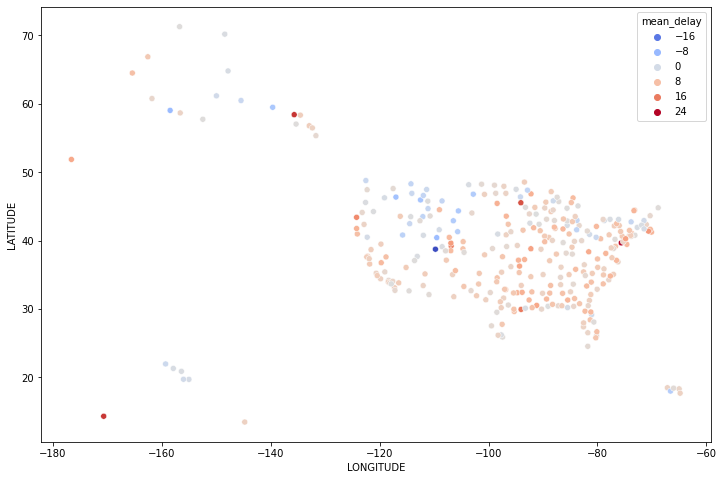

In [49]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=delay_map, hue='mean_delay', palette='coolwarm')
plt.show()

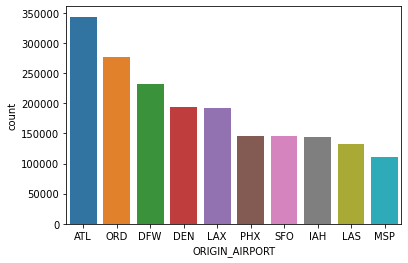

In [50]:
sns.countplot(x='ORIGIN_AIRPORT', data=df4, order=df4['ORIGIN_AIRPORT'].value_counts().iloc[:10].index)
plt.show()

In [51]:
state = df4.groupby('STATE').agg(count_state=('STATE', 'size'), unique_airports=('ORIGIN_AIRPORT', 'nunique'),
                                 mean_delay=('ARRIVAL_DELAY', 'mean')).reset_index()
state['per_one_airport'] = state['count_state'] / state['unique_airports']
state.sort_values('per_one_airport')

,STATE,count_state,unique_airports,mean_delay,per_one_airport
8,DE,95,1,24.063158,95.000000
3,AS,106,1,21.500000,106.000000
11,GU,331,1,4.839879,331.000000
53,WY,8047,6,-0.141792,1341.166667
0,AK,32754,19,1.451609,1723.894737
27,MT,14675,8,-1.169949,1834.375000
29,ND,16088,8,3.212084,2011.000000
52,WV,2315,1,10.653996,2315.000000
22,ME,4892,2,3.274734,2446.000000
48,VI,5103,2,4.210073,2551.500000


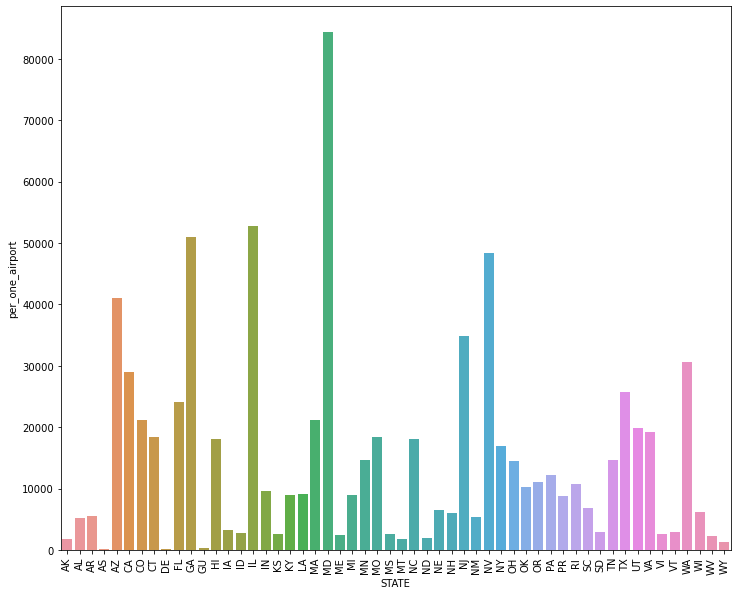

In [52]:
plt.figure(figsize=(12,10))
sns.barplot(x='STATE', data=state, y='per_one_airport')
plt.xticks(rotation=90)
plt.show()

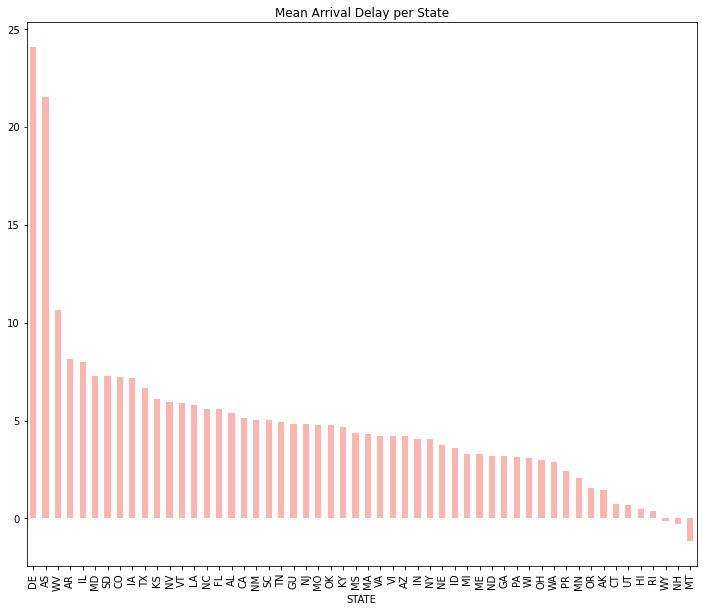

In [65]:
plt.figure(figsize=(12,10))
arrival_delay_per_state = df4.groupby('STATE')['ARRIVAL_DELAY'].mean()
arrival_delay_per_state.sort_values(ascending=False).plot(kind='bar', title='Mean Arrival Delay per State', colormap='Pastel1')
plt.show()

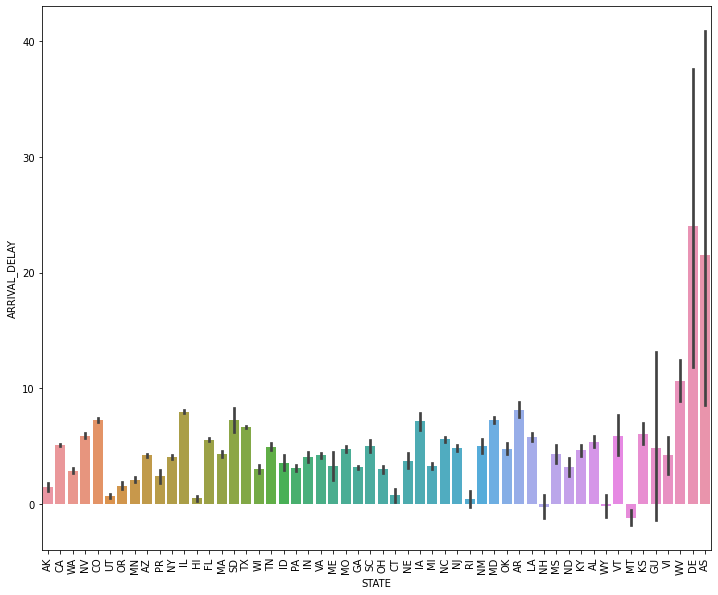

In [52]:
plt.figure(figsize=(12,10))
sns.barplot(x='STATE', y='ARRIVAL_DELAY' , data=df4)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

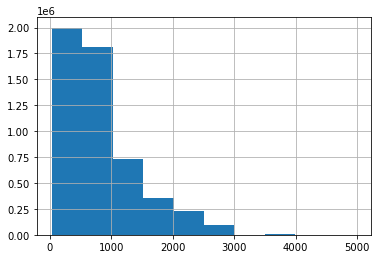

In [34]:
df_air['DISTANCE'].hist()

C:\Users\HP\AppData\Local\Temp\ipykernel_7624\3563824810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['distance_cat'] = pd.cut(df_air['DISTANCE'], bins=[0, 500, 1000, 2000, 5000],


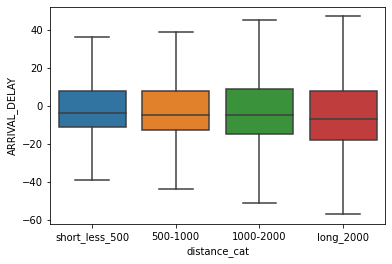

In [54]:
df_air['distance_cat'] = pd.cut(df_air['DISTANCE'], bins=[0, 500, 1000, 2000, 5000],
                              labels=['short_less_500', '500-1000', '1000-2000','long_2000'])
sns.boxplot(x='distance_cat', y='ARRIVAL_DELAY', data=df_air, showfliers=False)
plt.show()

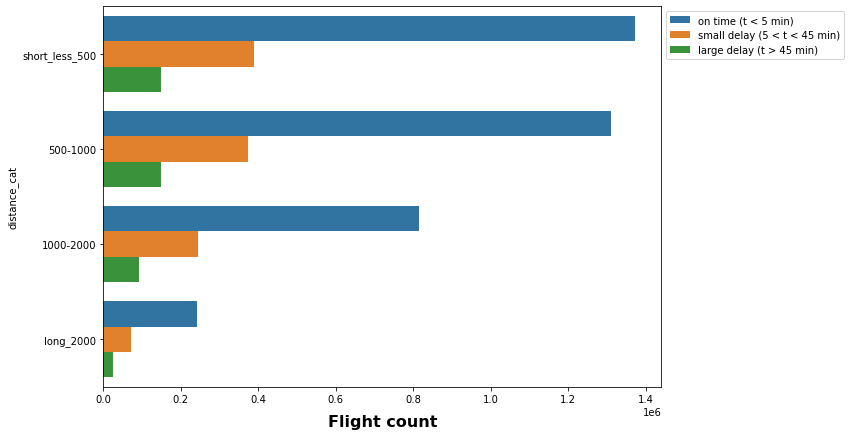

In [55]:
# Bar chart: Flight count delays vs day name
fig = plt.figure(1, figsize=(10,7))
sns.countplot(y="distance_cat", hue='DELAY_LEVEL', data=df_air)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [56]:
df_air.sample(10)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DATE,DAY_NAME,MONTH_NAME,SCHEDULED_DEPARTURE_H,SCHEDULED_ARRIVAL_H,DELAY_LEVEL,SCHEDULED_DEPARTURE_time,SCHEDULED_ARRIVAL_time,distance_cat
5675403,NK,SAN,ORD,237.0,1723,60.0,2015-12-22,Tuesday,December,14,20,2,afternoon,evening,1000-2000
2050021,DL,CHS,ATL,73.0,259,-16.0,2015-05-11,Monday,May,7,8,0,morning,morning,short_less_500
3623878,WN,BNA,DTW,90.0,456,31.0,2015-08-13,Thursday,August,16,19,1,afternoon,evening,short_less_500
3118324,EV,ORD,EVV,81.0,272,37.0,2015-07-14,Tuesday,July,19,20,1,evening,evening,short_less_500
1436725,B6,MCO,JFK,145.0,944,165.0,2015-04-02,Thursday,April,21,0,2,evening,night,500-1000
1955194,B6,BWI,BOS,81.0,369,-20.0,2015-05-05,Tuesday,May,8,9,0,morning,morning,short_less_500
5608410,EV,IAH,HSV,111.0,595,32.0,2015-12-18,Friday,December,10,12,1,morning,afternoon,500-1000
5694074,AA,LAS,LAX,74.0,236,63.0,2015-12-23,Wednesday,December,16,17,2,afternoon,afternoon,short_less_500
5103625,DL,SLC,BWI,242.0,1865,41.0,2015-11-15,Sunday,November,16,22,1,afternoon,evening,1000-2000
782168,OO,MSP,FCA,180.0,1026,9.0,2015-02-21,Saturday,February,11,13,1,morning,afternoon,1000-2000


### One Hot Encoding on Airline column

In [57]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 15 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   AIRLINE                   object        
 1   ORIGIN_AIRPORT            object        
 2   DESTINATION_AIRPORT       object        
 3   SCHEDULED_TIME            float64       
 4   DISTANCE                  int64         
 5   ARRIVAL_DELAY             float64       
 6   DATE                      datetime64[ns]
 7   DAY_NAME                  object        
 8   MONTH_NAME                object        
 9   SCHEDULED_DEPARTURE_H     int64         
 10  SCHEDULED_ARRIVAL_H       int64         
 11  DELAY_LEVEL               int64         
 12  SCHEDULED_DEPARTURE_time  object        
 13  SCHEDULED_ARRIVAL_time    object        
 14  distance_cat              category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 603.6+ MB


In [58]:
df_air.drop(['DESTINATION_AIRPORT', 'SCHEDULED_TIME', 'DISTANCE', 'ARRIVAL_DELAY', 'DATE',
            'SCHEDULED_DEPARTURE_H', 'SCHEDULED_ARRIVAL_H'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_7624\1237904255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air.drop(['DESTINATION_AIRPORT', 'SCHEDULED_TIME', 'DISTANCE', 'ARRIVAL_DELAY', 'DATE',


In [39]:
df_ohe = pd.get_dummies(data=df_air, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DAY_NAME', 'MONTH_NAME',
                                             'SCHEDULED_DEPARTURE_time', 'SCHEDULED_ARRIVAL_time', 'distance_cat'])

In [40]:
df_ohe.shape

(5231130, 367)

In [41]:
y=df_ohe.pop('DELAY_LEVEL')
X=df_ohe

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [81]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [43]:
# Modelling Libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
xgb = XGBClassifier(random_state=123)
xgb.fit(X_train, y_train)
xgb_results = xgb.predict(X_test)
score = roc_auc_score(y_test, xgb_results)
print(score)

ValueError: multi_class must be in ('ovo', 'ovr')

In [46]:
lr = LogisticRegression(random_state=123)
lr.fit(X_train, y_train)
lr_results = lr.predict(X_test)
score = accuracy_score(y_test, lr_results)
print(score)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7143141156881974


In [48]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
knn_results = knn.predict(X_test)
score = accuracy_score(y_test, knn_results)
print(score)

KeyboardInterrupt: 

In [49]:
lr1 = LogisticRegression(random_state=123, n_jobs=-1, max_iter=200)
lr1.fit(X_train, y_train)
lr1_results = lr1.predict(X_test)
score = accuracy_score(y_test, lr_results)
print(score)

0.7143141156881974


In [51]:
print(classification_report(y_test, lr_results))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83    747338
           1       0.24      0.00      0.00    215882
           2       0.47      0.00      0.00     83006

    accuracy                           0.71   1046226
   macro avg       0.48      0.33      0.28   1046226
weighted avg       0.60      0.71      0.60   1046226



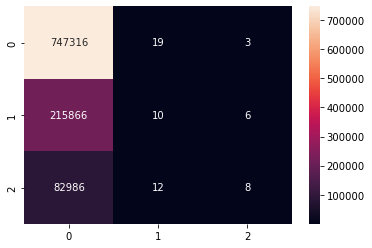

In [52]:
lr_cm=confusion_matrix(y_test, lr_results)
sns.heatmap(lr_cm, annot=True, fmt='d')
plt.show()

In [53]:
gb = GradientBoostingClassifier(random_state=123)
gb.fit(X_train, y_train)
gb_results = gb.predict(X_test)
score = accuracy_score(y_test, lr_results)
print(score)

0.7143141156881974


In [54]:
print(classification_report(y_test, gb_results))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83    747338
           1       0.00      0.00      0.00    215882
           2       0.43      0.00      0.00     83006

    accuracy                           0.71   1046226
   macro avg       0.38      0.33      0.28   1046226
weighted avg       0.54      0.71      0.60   1046226



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


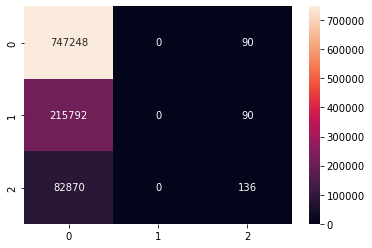

In [55]:
gb_cm=confusion_matrix(y_test, gb_results)
sns.heatmap(gb_cm, annot=True, fmt='d')
plt.show()